In [1]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

num_workers = 2 
batch_size = 32 
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(categories)
splits = ['train', 'val', 'test']

In [2]:
DATA_PATH =  'C:/Users/LENOVO/Desktop/COVID Project/CovidData'
MODEL_PATH = 'C:/Users/LENOVO/Desktop/COVID Project'

In [3]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

                code train val test  total
Covid              0   200  25   25    250
Normal             1   200  25   25    250
Viral Pneumonia    2   200  25   25    250
TOTAL                  600  75   75    750


In [4]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

In [5]:
len(dataset)

750

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cpu


Class: Covid


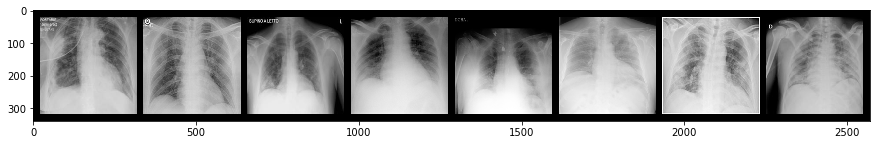

Class: Normal


<Figure size 432x288 with 0 Axes>

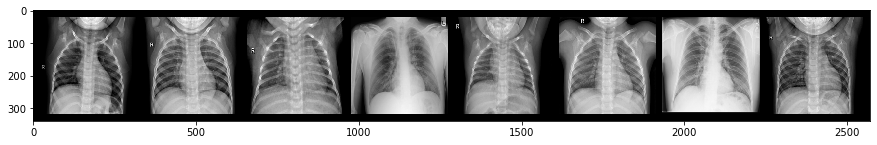

Class: Viral Pneumonia


<Figure size 432x288 with 0 Axes>

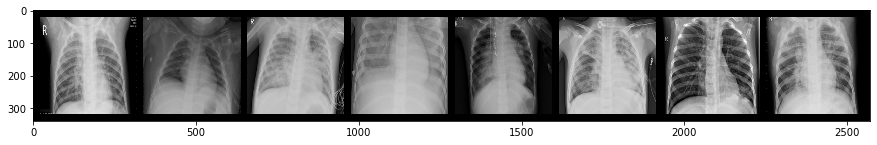

<Figure size 432x288 with 0 Axes>

In [7]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        plt.savefig('x-ray[i].pdf')  
        
show_batch_images(train_data)

In [8]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [9]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [10]:
from tqdm import tqdm
from torchvision import models
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'ResNet18'
n_epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

resnet18_model, df_epochs = train_val_model(model)

Training model ResNet18 with 600 samples and max of 20 epochs, and validating with 75 samples

Epoch 1:	 train loss=1.15961 	 val loss=1.22356 	 time=57.08s
Epoch 2:	 train loss=1.04802 	 val loss=1.15539 	 time=56.23s
Epoch 3:	 train loss=0.98679 	 val loss=0.96988 	 time=65.21s
Epoch 4:	 train loss=0.93450 	 val loss=0.84438 	 time=63.43s
Epoch 5:	 train loss=0.88611 	 val loss=0.79065 	 time=63.90s
Epoch 6:	 train loss=0.84898 	 val loss=0.73994 	 time=64.89s
Epoch 7:	 train loss=0.80972 	 val loss=0.69574 	 time=66.74s
Epoch 8:	 train loss=0.77481 	 val loss=0.65617 	 time=64.77s
Epoch 9:	 train loss=0.74619 	 val loss=0.62863 	 time=61.82s
Epoch 10:	 train loss=0.71950 	 val loss=0.59414 	 time=62.39s
Epoch 11:	 train loss=0.69685 	 val loss=0.56491 	 time=63.74s
Epoch 12:	 train loss=0.67243 	 val loss=0.52809 	 time=65.14s
Epoch 13:	 train loss=0.66316 	 val loss=0.50833 	 time=63.32s
Epoch 14:	 train loss=0.63904 	 val loss=0.49180 	 time=61.44s
Epoch 15:	 train loss=0.63174 	 

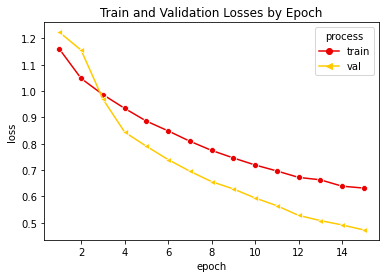

In [12]:
plot_train_val_losses(df_epochs)

In [13]:
test_results, conf_matrix_test = accuracy_model(resnet18_model, test_loader)

Testing the model ResNet18 with 75 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.933333   0.936847  0.933333  0.933223


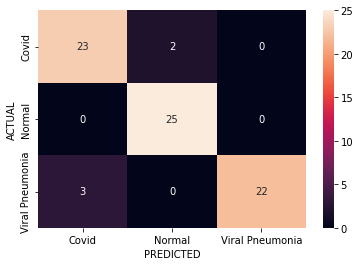

In [14]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [15]:
torch.save(resnet18_model.state_dict(), os.path.join(MODEL_PATH, 'resnet18.pth'))

In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
dataset = ImageFolder(DATA_PATH, 
                     transform=transforms.Compose([
                         transforms.Resize(299),
                         transforms.CenterCrop(299),
                         transforms.ToTensor(), 
                     ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle = False)

Dataset ImageFolder
    Number of datapoints: 750
    Root location: C:/Users/LENOVO/Desktop/COVID Project/CovidData
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(299, 299))
               ToTensor()
           )


In [17]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299), 
        transforms.ToTensor(), 
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) 
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 0: print(f"predicted ----> COVID")
        elif preds[0] == 1: print(f"predicted ----> NORMAL")
        else: print(f"predicted ----> PNEUMONIC")

In [21]:
if __name__ == "__main__":
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Covid/COVID-230.png") 
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Normal/Normal-242.png") 
    RandomImagePrediction("C:/Users/LENOVO/Desktop/COVID Project/CovidData/val/Viral Pneumonia/Viral Pneumonia-247.png") 

class : tensor([0])
predicted ----> COVID
class : tensor([1])
predicted ----> NORMAL
class : tensor([2])
predicted ----> PNEUMONIC
class : tensor([0])
class : tensor([1])
class : tensor([2])
class : tensor([2])


In [19]:
import anvil.server

anvil.server.connect("ZOWPHTHH7UTXEWTWRKARPK2P-YSKMUI6OSW7E7V2L")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [20]:
import anvil.media

@anvil.server.callable
def predict_image(file):
    with anvil.media.TempFile(file) as filename:
        img_array = Image.open(filename).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299), 
        transforms.ToTensor(), 
    ])
    img = data_transforms(img_array).unsqueeze(dim=0)
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 0: return "COVID"
        elif preds[0] == 1: return "NORMAL"
        else: return "PNEUMONIC"